# 1 Creation of the Learning Environment

In [1]:
import gym
import numpy as np
import pandas as pd

In [2]:
env = gym.make('CartPole-v1')

In [3]:
obs = env.reset()
obs

array([-0.00441444,  0.04358954, -0.00100114, -0.04720588], dtype=float32)

In [4]:
def showObs(theObs):
    print('Position       =', theObs[0], '0 = centre, >0 = means to the right')
    print('Speed          =', theObs[1])
    print('Angle          =', theObs[2])
    print('Rotation speed =', theObs[3])

In [5]:
showObs(obs)

Position       = -0.004414436 0 = centre, >0 = means to the right
Speed          = 0.043589536
Angle          = -0.0010011417
Rotation speed = -0.04720588


In [6]:
env.action_space

Discrete(2)

In [7]:
env.action_space.n

2

In [8]:
push_left = 0
push_right = 1

In [9]:
env.observation_space.low

array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32)

In [10]:
env.observation_space.high

array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)

In [11]:
action = push_right
obs, reward, done, info = env.step(action)

In [12]:
showObs(obs)

Position       = -0.0035426451 0 = centre, >0 = means to the right
Speed          = 0.23872583
Angle          = -0.0019452594
Rotation speed = -0.3402045


In [13]:
reward

1.0

In [14]:
done

False

In [15]:
info

{}

# 2 A simple attempt at controlling the cart-pole (Does not work!)

In [16]:
def simple_policy(obs):
    angle = obs[2]
    return 0 if angle<0 else 1

In [17]:
totals = []
for episode in range(500):
    obs = env.reset()
    episode_rewards = 0
    for step in range(200):
        action = simple_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

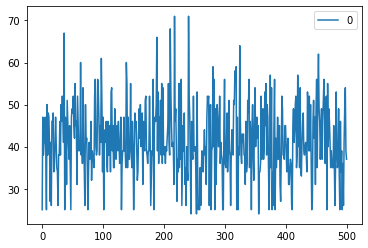

In [18]:
totals_chart = pd.DataFrame(totals)
ax = totals_chart.plot.line()

In [19]:
totals_chart.describe()

0
count  500.000000
mean    41.348000
std      8.763361
min     24.000000
25%     36.000000
50%     40.000000
75%     47.000000
max     71.000000

# 2 Q-Learning

In [21]:
import math
%matplotlib notebook
from matplotlib import pyplot as plt

In [22]:
env = gym.make('CartPole-v0')

## 2.1 Defining the Q-table

In [23]:
buckets = (1,1,6,12,)
buckets

(1, 1, 6, 12)

In [24]:
Q = np.zeros(buckets + (env.action_space.n,))

In [25]:
np.zeros(5)

array([0., 0., 0., 0., 0.])

In [26]:
array_shape = (2,3)
np.zeros(array_shape)

array([[0., 0., 0.],
       [0., 0., 0.]])

In [28]:
array_shape = (2,3,4)
np.zeros(array_shape)

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [29]:
buckets + (env.action_space.n,)

(1, 1, 6, 12, 2)

In [30]:
# initialising Q-table
Q = np.zeros(buckets + (env.action_space.n,))
Q

array([[[[[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0

## 2.2 Defining other controlling variables

In [31]:
n_episodes = 200
min_alpha = 0.1
min_epsilon = 0.1
gamma = 1.0
ada_divisor = 25
max_env_steps = None
monitor = False

## 2.3 Translating the state from Continuous to Discrete values

In [36]:
def discretize(obs):
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians[50]]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians[50]]
    ratios = [(obs[i]+abs(lower_bounds[i]))/(upper_bounds[i]-lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((buckets[i]-1)*ratios[i])) for i in range(len(obs))]
    new_obs = [min(buckets[i]-1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

In [37]:
showObs(obs)

Position       = -0.19486855 0 = centre, >0 = means to the right
Speed          = -0.20432314
Angle          = 0.21072032
Rotation speed = 0.17696178


In [38]:
discrete_obs = discretize(obs)
showObs(discrete_obs)

TypeError: 'builtin_function_or_method' object is not subscriptable

## 2.4 Selecting an Action based on the Q-Table

In [39]:
np.argmax([1,2,1,6,2,4])

3

In [40]:
# Choosing action based on epsilon-greedy policy
def choose_action(state, epsilon):
    return env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(Q[state])

## 2.5 Learning! .. Updating the Q-Table based on the reward

In [41]:
# Updating Q-value of state-action pair based on the update equation
def update_q(state_old, action, reward, state_new, alpha):
    Q[state_old][action] += alpha*(reward+gamma*np.max(Q[state_new])-Q[state_old][action])

## 2.6 Adaptive rates for Learning and Exploration

In [42]:
# Adaptive learning of Exploration Rate
def get_epsilon(t):
    return max(min_epsilon, min(1, 1.0-math.log10((t+1)/ada_divisor)))

In [43]:
# Adaptive learning of Learning Rate
def get_alpha(t):
    return max(min_alpha, min(1.0, 1.0-math.log10((t+1)/ada_divisor)))

## 2.7 The main learning loop

<IPython.core.display.Javascript object>


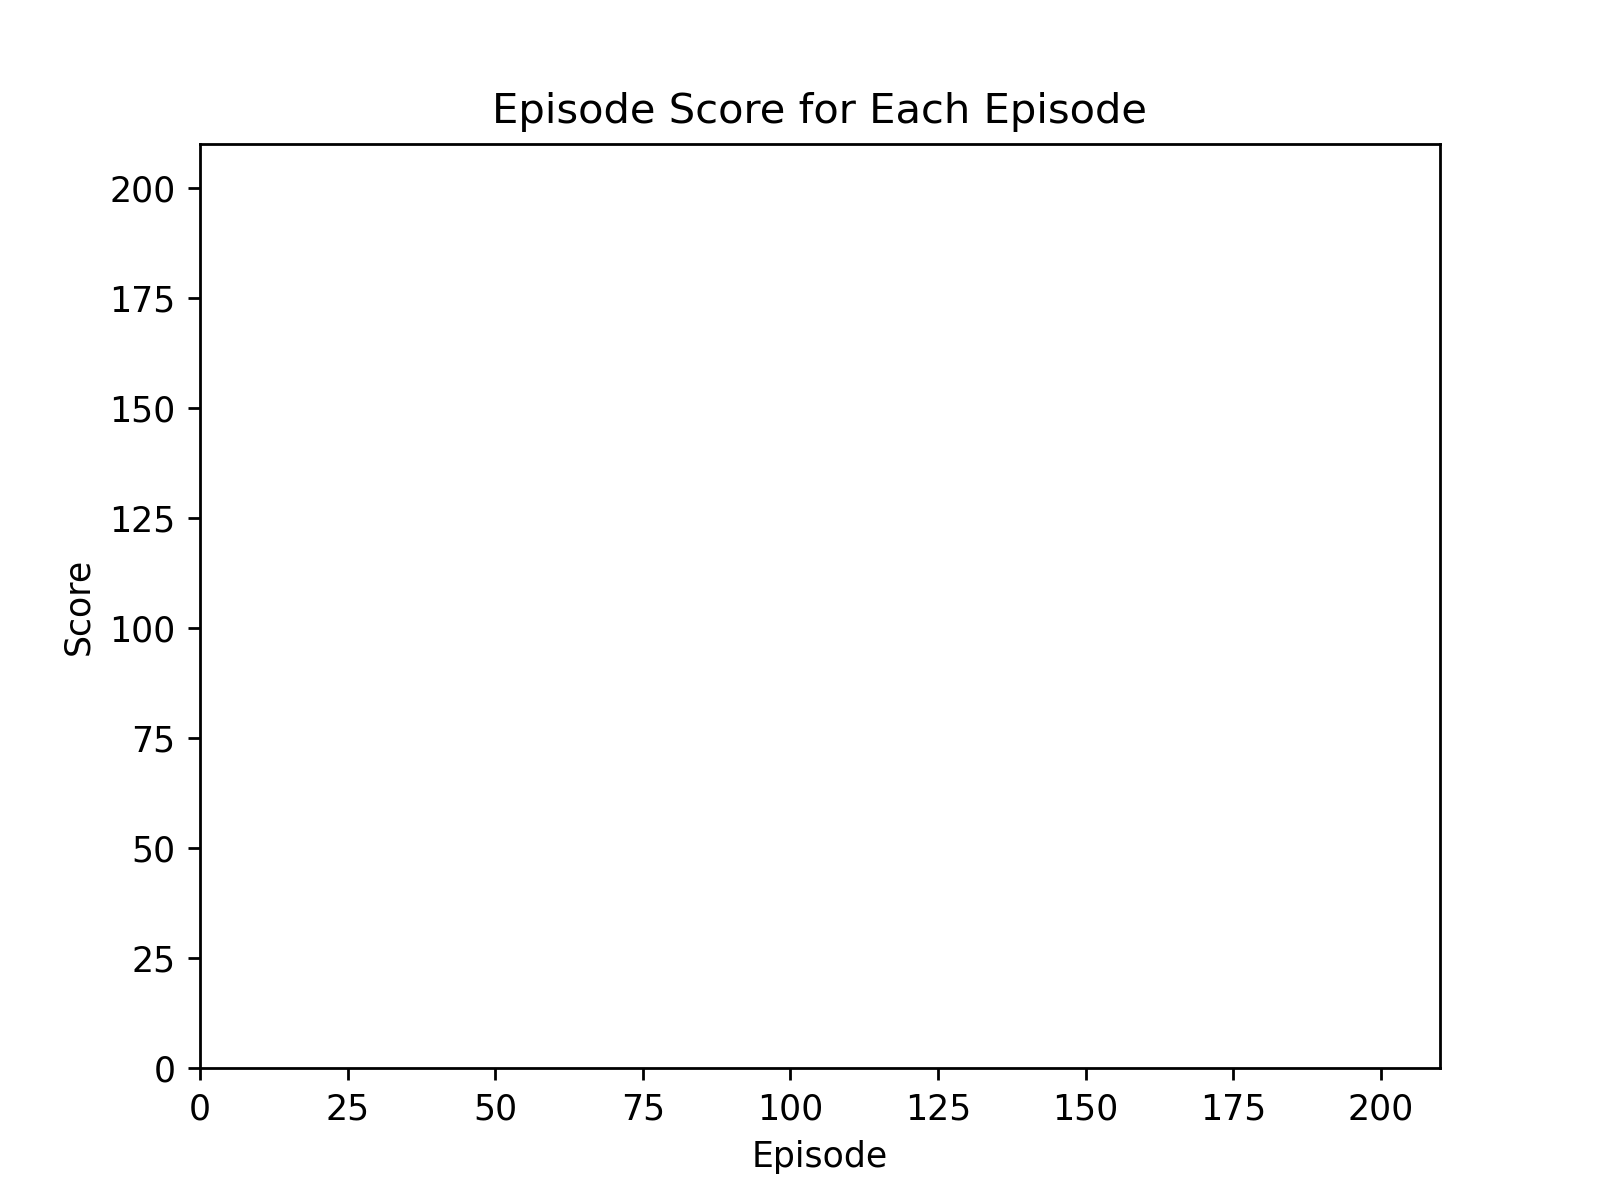

TypeError: 'builtin_function_or_method' object is not subscriptable

In [44]:
y_chart = []
x_chart = []
plt.figure(100)
plt.xlim((0,210))
plt.ylim((0,210))
plt.title('Episode Score for Each Episode')
plt.ylabel('Score')
plt.xlabel('Episode')

for e in range(n_episodes):
    current_state = discretize(env.reset())
    alpha = get_alpha(e)
    epsilon = get_epsilon(e)
    done = False
    i = 0
    total_reward = 0
    while not done:
        env.render()
        action = choose_action(current_state, epsilon)
        obs, reward, done, _=env.step(action)
        new_state = discretize(obs)
        update_q(current_state, action, reward, new_statew_state, alpha)
        current_state = new_state
        i += 1
        total_reward += reward
        y_chart.append(total_reward)
        x_chart.append(e)
        plt.plot(x_chart, y_chart, color='blue')
        plt.show()
        plt.pause(0.01)
    env.close()